# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [161]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [162]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU')
else:
    print('CUDA is available!  Training on GPU')

CUDA is not available.  Training on CPU


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [163]:
traindata =  torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transforms.ToTensor())

#calculate the mean and standard deviation for normalisation:

train_images = torch.stack([image for image, _ in traindata], dim=3)
mean, std = train_images.view(3, -1).mean(dim=1), train_images.view(3, -1).std(dim=1)

# Define transforms

train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])


test_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [164]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


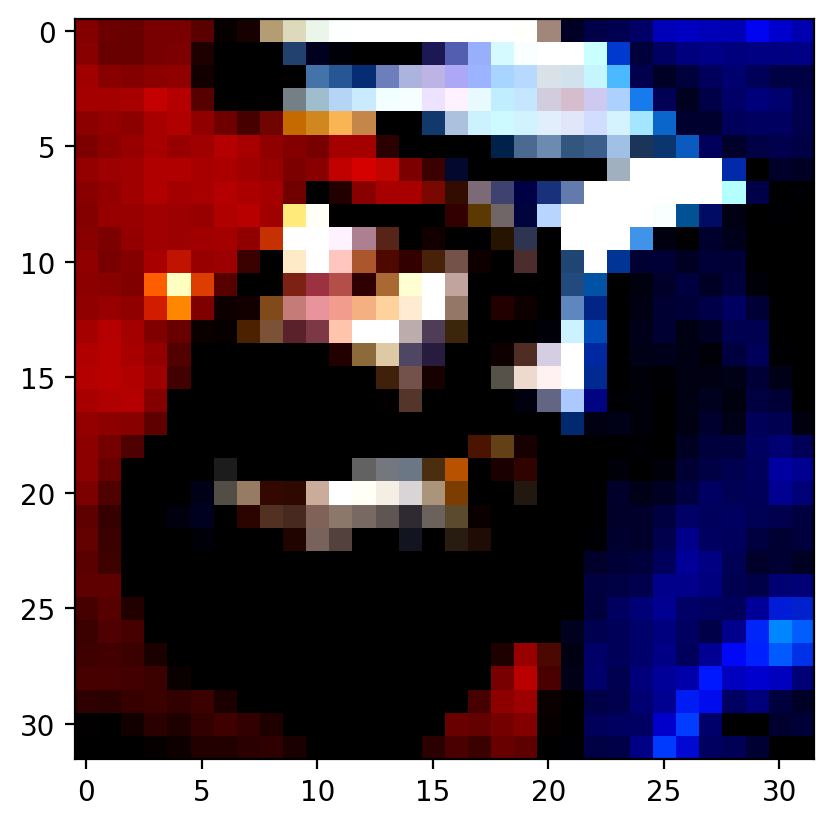

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


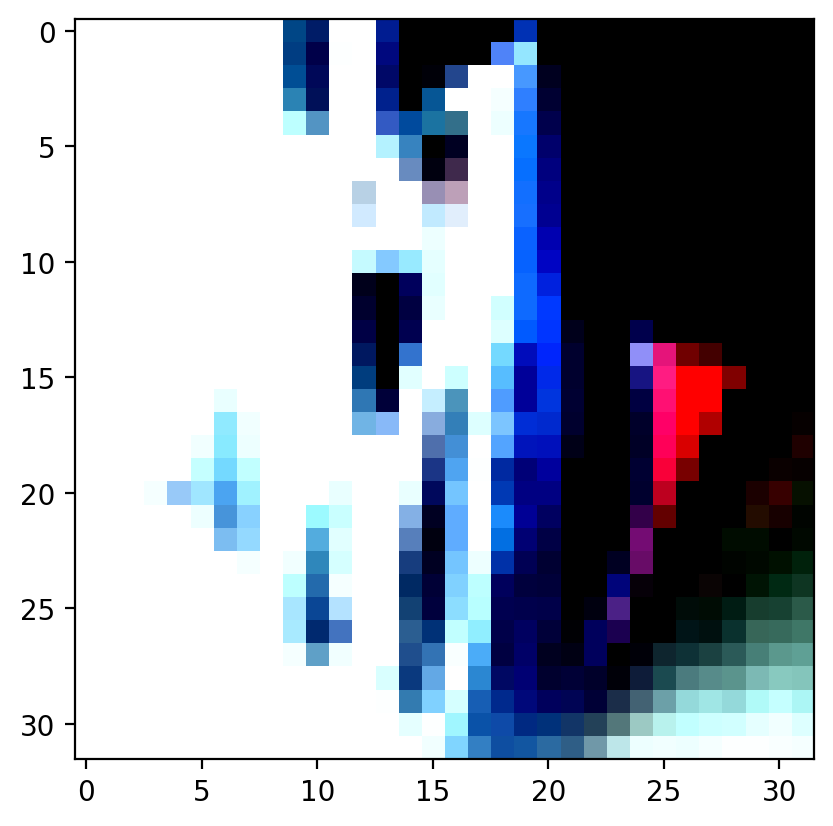

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


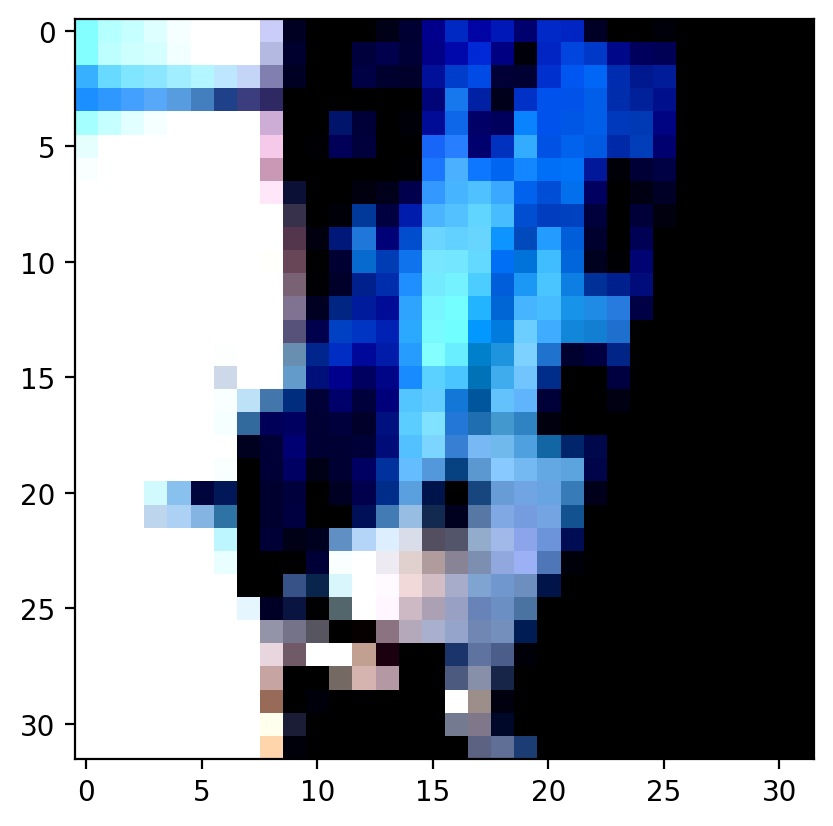

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


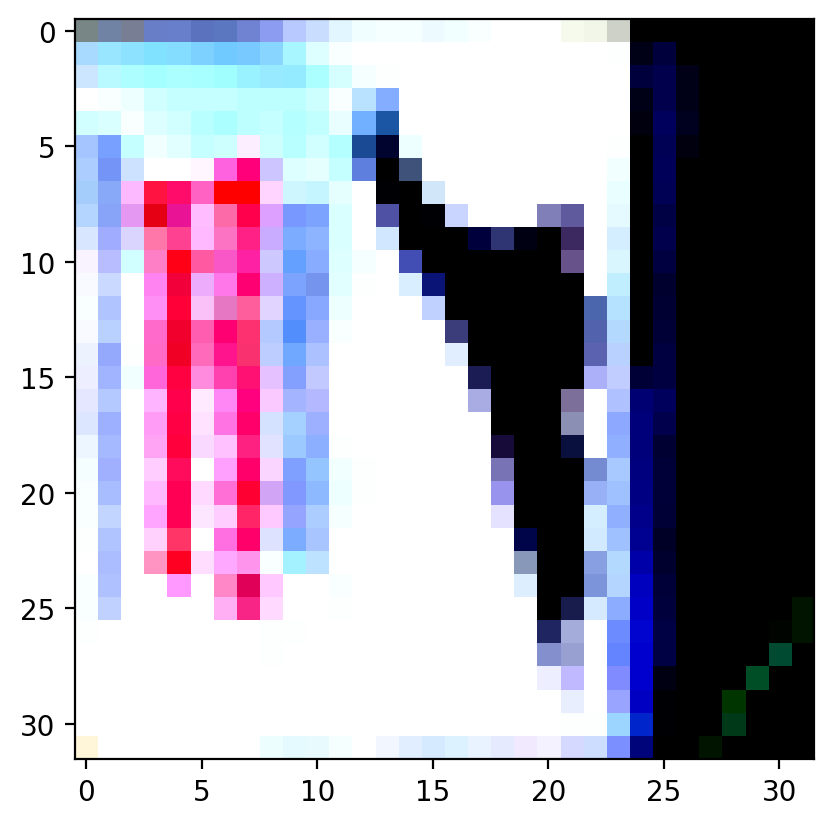

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


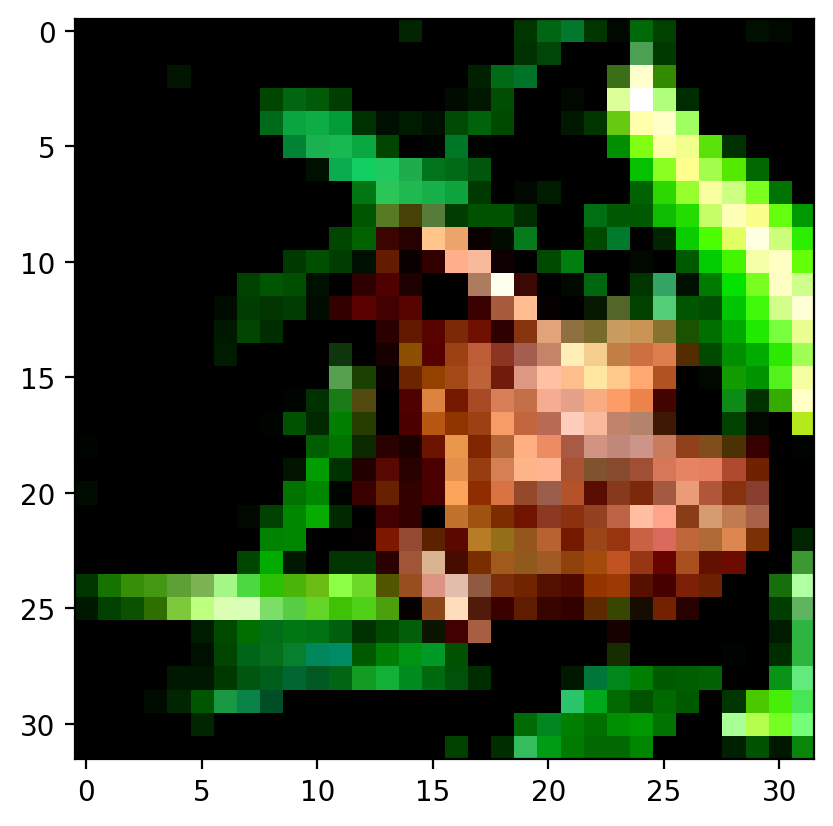

Image size: 32x32 pixels
Images shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32])


In [181]:
## YOUR CODE HERE ##
show5(testloader)
dataiter = iter(testloader)
images, labels = next(dataiter)

# - Print size of image(s)
batch = next(iter(trainloader))
image = batch[0][0][0:1]
print('Image size: {}x{} pixels'.format(image.size(1), image.size(2)))

# The shape of the training data:
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [167]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Build a feed-forward network:

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)

        self.dropout = nn.Dropout(p=.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1) # flatten all dimensions except batch

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))

        x = F.log_softmax(self.fc5(x), dim = 1)

        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [168]:
model = Classifier()

# Cross Entropy loss function:
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent optimizer:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [169]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device) # Transfer model to default device
epochs = 30
train_losses, test_losses, acurracies = [], [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device) # Transfer images and labels to default device
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        acurracies.append(test_correct/ len(testloader.dataset))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/30..  Training Loss: 0.061..  Test Loss: 0.054..  Test Accuracy: 0.380
Epoch: 2/30..  Training Loss: 0.053..  Test Loss: 0.052..  Test Accuracy: 0.403
Epoch: 3/30..  Training Loss: 0.050..  Test Loss: 0.049..  Test Accuracy: 0.449
Epoch: 4/30..  Training Loss: 0.049..  Test Loss: 0.048..  Test Accuracy: 0.457
Epoch: 5/30..  Training Loss: 0.048..  Test Loss: 0.047..  Test Accuracy: 0.464
Epoch: 6/30..  Training Loss: 0.046..  Test Loss: 0.047..  Test Accuracy: 0.463
Epoch: 7/30..  Training Loss: 0.046..  Test Loss: 0.045..  Test Accuracy: 0.488
Epoch: 8/30..  Training Loss: 0.045..  Test Loss: 0.046..  Test Accuracy: 0.486
Epoch: 9/30..  Training Loss: 0.044..  Test Loss: 0.045..  Test Accuracy: 0.488
Epoch: 10/30..  Training Loss: 0.044..  Test Loss: 0.045..  Test Accuracy: 0.487
Epoch: 11/30..  Training Loss: 0.043..  Test Loss: 0.045..  Test Accuracy: 0.490
Epoch: 12/30..  Training Loss: 0.043..  Test Loss: 0.045..  Test Accuracy: 0.497
Epoch: 13/30..  Training Loss: 0.042.

Plot the training loss (and validation loss/accuracy, if recorded).

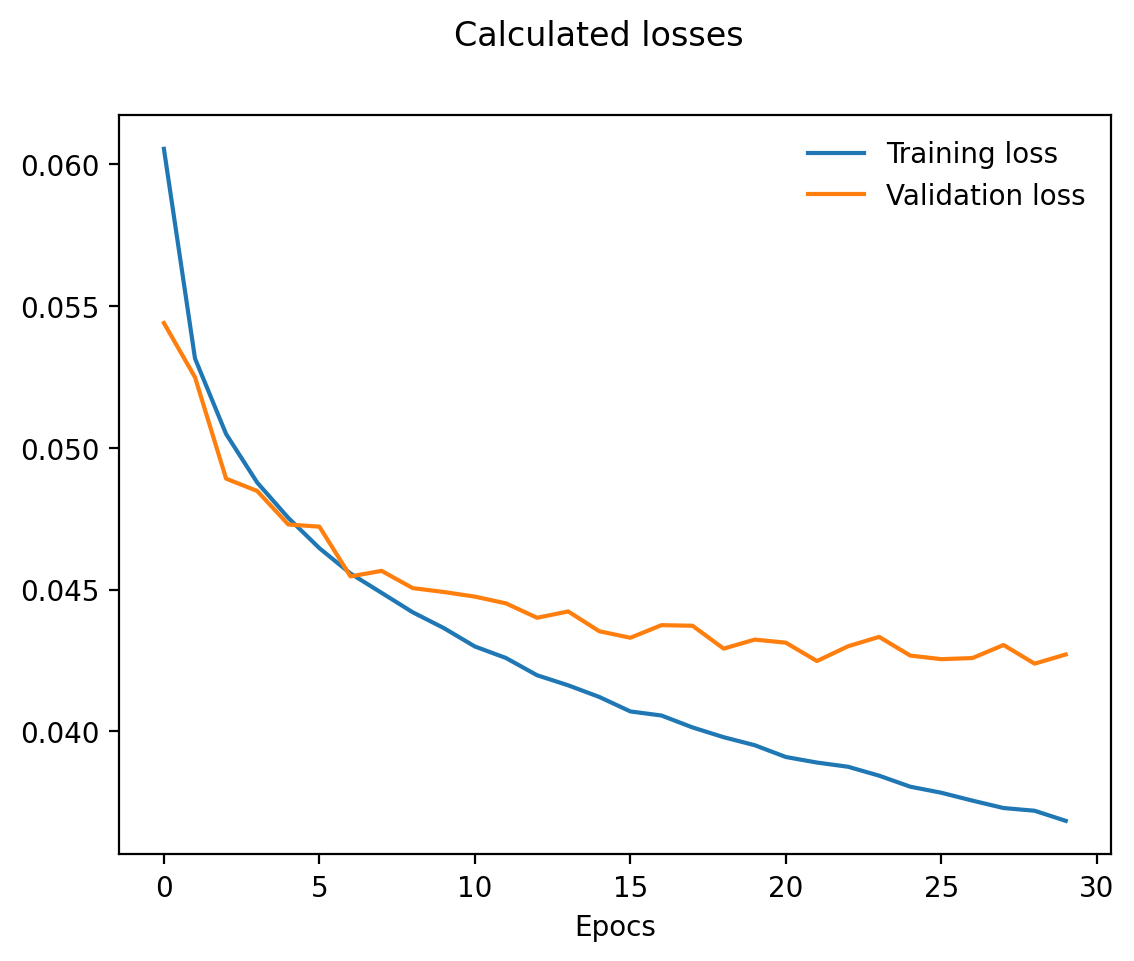

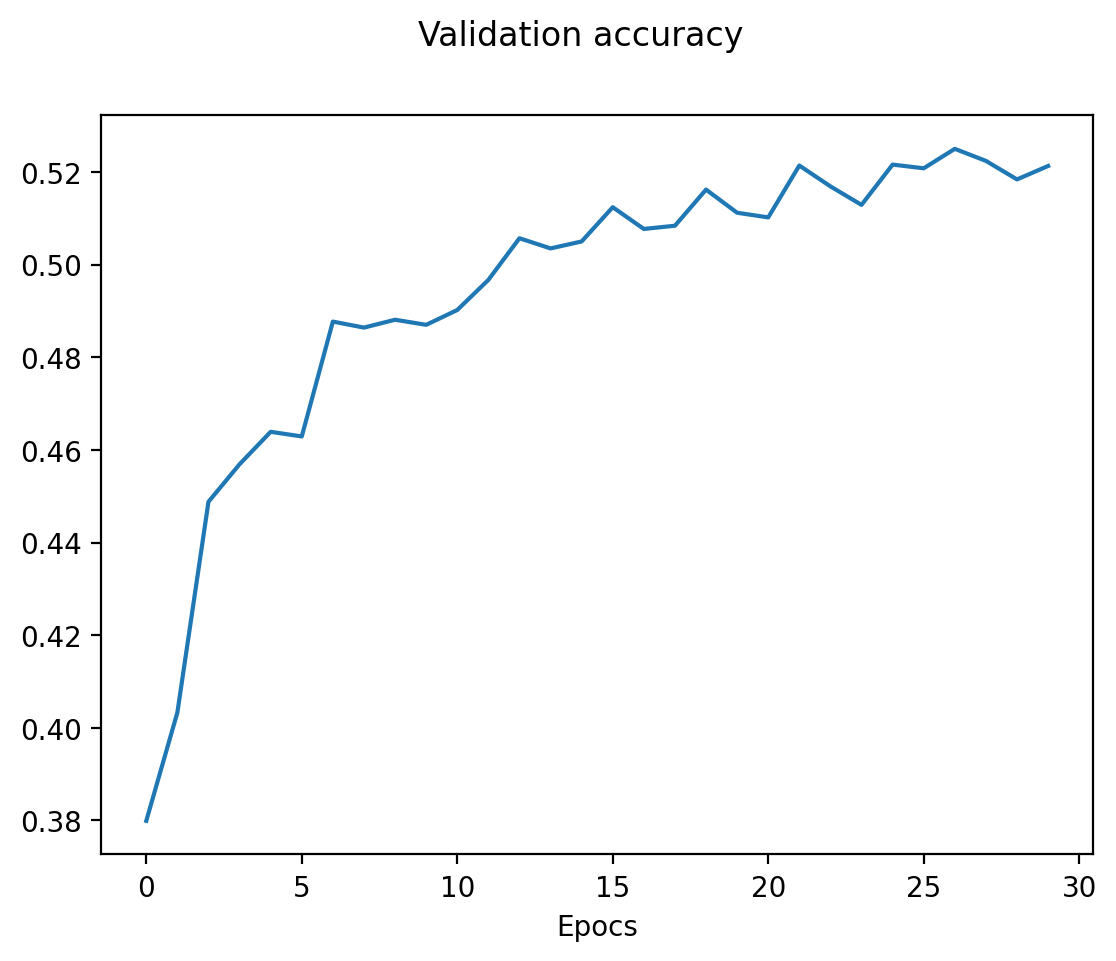

In [192]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.suptitle('Calculated losses')
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel('Epocs')
plt.legend(frameon=False)
plt.show()

plt.suptitle('Validation accuracy')
plt.plot(acurracies)
plt.xlabel('Epocs')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [203]:
accuracy = 0
model.eval()
with torch.no_grad():  # no gradient calculation since not training
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)  # Transfer images and labels to default device
        log_ps = model.forward(images)
        t_loss = criterion(log_ps, labels)                
        test_loss += t_loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()      
model.train()                   
print("Model Accuracy: {:.2f}%".format(accuracy / len(testloader)*100))


Model Accuracy: 54.69%


## Saving your model
Using `torch.save`, save your model for future loading.

In [191]:
checkpoint = {'state_dict':model.state_dict(),
              'optimizer': optimizer,
              'criterion': criterion,
              'epochs':epochs}

torch.save(checkpoint, 'checkpoint.pt')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.


1. The trained model achieved 54.7% accuracy on the CIFAR-10 Dataset. This is lower than the result of the Detectocorp's algorithm with 70%.
2. My suggestion is buying the Detectocorp’s algorithm, which has 70% accuracy rate. 


